<a href="https://colab.research.google.com/github/isabellebouchard/ift6135/blob/master/Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3

**Instructions**: [Read the rules](https://https://www.kaggle.com/c/ift6135h19/rules) !

The deadline for submissions is February 15th. It is one day before the assignment deadline.

The train and test sets are available in the 'Data' tab. You are responsible for splitting the train set to an actual train and valid sets yourself.

Once you train a model, you should run it on a test set, and generate a CSV file similar to the sample submission ('sample_submission.csv'), that should specify the class for all images of the test set.

Please remember to have ONE MEMBER OF EACH TEAM making all the submissions for the team.

Your submissions will be compared to the ground truth, using the mean classification accuracy metric

The public leaderboard shows your score, calculated with the ground truth of part of the test set. The private leaderboard (only available at the end of the competition) uses the rest of the test set to evaluate your answers. The latter is the score that will be used in grading. This will encourage you to not overfit the test data. Two of your submissions are eligible for the final private leaderboard. You can hand-select the eligible submissions, or it will otherwise default to the best public scoring submissions.

Your score will be taken into account to determine your grade. A score of 0.5 (random guessing or constant classifiers for example) will correspond to a mark of 0%. A score of 0.75 will correspond to a mark of 95% (on this part of the assignment). We will use a concave function on the interval [0.5, 0.75] to determine your mark as a function of the score here. The 5 teams with the highest scores will get a mark of 100% on this part of the assignment.

You can have as much as 4 submissions per UTC day. Please note that this is not an invitation to make dozens of submissions during the competition. The goal of the assignment is for you to apply what you learned in class while having fun.






### Installation Requirements

In [0]:
# imgaug requirements
!pip3 install six numpy scipy Pillow scikit-image opencv-python imageio Shapely
!pip3 install torch torchvision matplotlib imgaug>=0.2.7,<0.2.8

!google-drive-ocamlfuse -cc

/bin/bash: 0.2.8: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found


### Use GPU 

First, select "GPU" in the Edit Menu -> Notebook Settings -> Hardware Accelerator -> GPU

**torch.cuda**: *This package adds support for CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation.*

**torch.cuda.is_available()**: *Returns a bool indicating if CUDA is currently available.*

To go from a tensor type CPU to GPU, add .to("cuda:0")

In [0]:
import torch

use_gpu = torch.cuda.is_available()
print("GPU Available: {}".format(use_gpu))
device = torch.device("cuda:0" if use_gpu else "cpu")

GPU Available: True


### Get Zipped Data on Colab 
Rather than uploading the data file to the drive (too large!), its better to upload the zipped data file and unzip it within colab. Make sure the zipped data file is at the same level in your file system as this current file (root). 

1. Mount your Drive to Colab and unzip the data file. 
2. Then force move it to the location you want (@root with this file)

*do this once and comment out afterwards

In [0]:
! ls drive/My\ Drive/Colab\ Notebooks/data.zip

'drive/My Drive/Colab Notebooks/data.zip'


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


#ENTER THE PATH FROM YOUR GOOGLE DRIVE TO data.zip AND test.zip
!unzip drive/My\ Drive/Colab\ Notebooks/data.zip
# !mv --force data "./drive/My\ Drive/Colab\ Notebooks/IFT6135-Assignments/ift6135/assignements"

!unzip drive/My\ Drive/Colab\ Notebooks/testset.zip
# !mv --force testset "./drive/My\ Drive/Colab\ Notebooks/IFT6135-Assignments/ift6135/assignements"

!ls testset/test/ | wc -l

Mounted at /content/drive
Archive:  drive/My Drive/Colab Notebooks/data.zip
replace data/cat_dog_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/cat_dog_data/.DS_Store  
  inflating: __MACOSX/data/cat_dog_data/._.DS_Store  
  inflating: data/cat_dog_data/train/dogs/9733.jpg  
  inflating: data/cat_dog_data/train/dogs/14147.jpg  
  inflating: data/cat_dog_data/train/dogs/63.jpg  
  inflating: data/cat_dog_data/train/dogs/12536.jpg  
  inflating: data/cat_dog_data/train/dogs/823.jpg  
  inflating: data/cat_dog_data/train/dogs/15259.jpg  
  inflating: data/cat_dog_data/train/dogs/4217.jpg  
  inflating: data/cat_dog_data/train/dogs/3578.jpg  
  inflating: data/cat_dog_data/train/dogs/2666.jpg  
  inflating: data/cat_dog_data/train/dogs/11981.jpg  
  inflating: data/cat_dog_data/train/dogs/17328.jpg  
  inflating: data/cat_dog_data/train/dogs/10447.jpg  
  inflating: data/cat_dog_data/train/dogs/2100.jpg  
  inflating: data/cat_dog_data/train/dogs/11759.jpg  
  in

### Hyperparameters



In [0]:
learning_rate = 5e-3
batch_size = 6

### Kaggle Data

**trainset.zip** - zip file with 2 folders ('Cat' and 'Dog') containing the training images

**test.csv** - zip file with 1 folder ('test') that contains the images you should classify - the goal of having the 'test' folder is for you to be able to use 'datasets.ImageFolder'

**sample_submission.csv** - a sample submission file in the correct format - your submission should be **EXACTLY** in this format for the evaluation to work

### Data Agumentation
To prevent overfitting, we augmented our data in the training set by doing rotations, horizontal flips, and resize crops. We also normalized the data in both training and validation sets. 

In [0]:
!pip3 install --upgrade scikit-image
!pip3 install --upgrade numpy
!pip3 install --upgrade pandas
# !pip install --no-cache-dir -I pillow
# !pip3 install py3

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.14.2)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.1)
Requirement already up-to-date: imgaug in /usr/local/lib/python3.6/dist-packages (0.2.8)


In [0]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import imgaug as ia
from PIL import Image

data_dir = './data/cat_dog_data'


class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return Image.fromarray(self.aug.augment_image(img))

  
#from: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
  """Custom dataset that includes image file paths. Extends
  torchvision.datasets.ImageFolder
  """

  # override the __getitem__ method. this is the method dataloader calls
  def __getitem__(self, index):
    # this is what ImageFolder normally returns 
    original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
    # the image file path
    path = self.imgs[index][0]
    # make a new tuple that includes original and the path
    tuple_with_path = (original_tuple + (path,))
    return tuple_with_path



# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        ImgAugTransform(),
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}

test_set = ImageFolderWithPaths(root='./testset', transform=data_transforms['test'])
testset = DataLoader(test_set, batch_size=batch_size, shuffle=False)


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('Train_size',dataset_sizes['train'])
print('Val_size',dataset_sizes['val'])
print('Test_size',len(test_set))
class_names = image_datasets['train'].classes

Train_size 17498
Val_size 2500
Test_size 4999


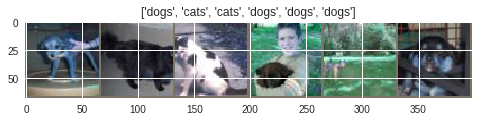

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### CNN Model

[torch.nn.Module](https://pytorch.org/docs/master/nn.html#torch.nn.Module): Base class for all NN modules. 
Must implement __init__ (defines the layers) and **forward** (returns the output)

[torch.nn.Sequential(*args)](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential): Modules will be added to it in the order they are passed in the constructor

 [torch.nn.Conv2d](https://pytorch.org/docs/master/nn.html#torch.nn.Conv2d)(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
 
[torch.nn.MaxPool2d](https://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d)(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False): Applies a 2D max pooling over an input signal composed of several input planes.

 [torch.nn.Linear](https://pytorch.org/docs/master/nn.html#torch.nn.Linear)(in_features, out_features, bias=True)


In [0]:
import torch.nn as nn
import copy

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Sequential(  
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.Conv2d(32,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2))
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.Conv2d(64,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2))

    self.conv3 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.Conv2d(128,128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2))
    
    self.conv4 = nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=1),
        nn.Conv2d(256,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2))
    
    self.fc = nn.Linear(4*4*256, 2)
    
  def forward(self,x):
    out0 = self.conv1(x)
    out1 = self.conv2(out0)
    out2 = self.conv3(out1)
    out3 = self.conv4(out2)
    flatten = out3.view(out3.size(0),-1)
    fc = self.fc(flatten)
    # We return every output layer to visualize!
    return fc, out0, out1, out2, out3, flatten

model = CNN()
# put model on GPU
model = model.to(device)

print(model)

print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))

# Save the initial weights of model
init_model_wts = copy.deepcopy(model.state_dict())

### Train CNN

#### Loss function

criterion = [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss)(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

#### Minimize loss function using stochastic gradient descent
optimizer = [torch.optim.SGD](https://pytorch.org/docs/master/optim.html#torch.optim.SGD)(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)


In [0]:
import time

num_epochs = 10
patience = 0

#loss function
criterion = nn.CrossEntropyLoss()  

#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.load_state_dict(init_model_wts)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_errors = []
eval_errors = []
acc = []

print("Training begins...")
since = time.time()

for epoch in range(num_epochs):
  
  train_error = 0
  train_num = 0
  
  #model in train mode
  model.train()
  
  for i,(images,labels) in enumerate(dataloaders['train']):
    
    # images and labels on GPU
    images = images.to(device)
    labels = labels.to(device)
    
    # zero gradient buffer
    optimizer.zero_grad()

    # forward pass
    outputs = model(images)[0]
            
    # loss function
    loss = criterion(outputs,labels)
        
    # backward pass
    loss.backward()
    
    # gradient descent step
    optimizer.step()
    
    # add the loss
    train_error += loss.item()
    train_num += 1
  
  eval_error = 0
  eval_num = 0
  correct = 0
  total = 0
  
  #model in eval mode
  model.eval()
  
  for i,(images,labels) in enumerate(dataloaders['val']):
    
    # images and labels on GPU
    images = images.to(device)
    labels = labels.to(device)
        
    # forward pass
    outputs = model(images)[0]
    _, predicted = torch.max(outputs.data, 1)
    
    # loss function
    loss = criterion(outputs,labels)
        
    # add the loss
    eval_error += loss.item()
    eval_num += 1
    
    # save the accuary
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)
  
  #calculate epoch accuracy
  accuracy = (100 * correct)/total
    
  # deep copy the model of best epoch accuracy
  if accuracy > best_acc:
    best_acc = accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 0
  else:
    patience += 1

  if patience > 4:
    print('early stopping')
    break
    
  # save the loss
  train_errors.append(train_error / train_num)
  eval_errors.append(eval_error / eval_num)
  
  acc.append(accuracy)
  
  #print stats after each epoch
  print('\nEpoch {}'.format(epoch + 1))
  print('\nPatience {}'.format(patience))
  print('\tTrain error: {:.4f}'.format(train_error/train_num))  
  print('\tEval error: {:.4f}'.format(eval_error/eval_num))
  print('\tAccuracy on Eval set: {:.2f}%'.format(accuracy))
  
time_elapsed = time.time() - since
print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best Eval Acc: {:.2f}%'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)

  

Training begins...

Epoch 1

Patience 0
	Train error: 0.6930
	Eval error: 0.6925
	Accuracy on Eval set: 50.00%

Epoch 2

Patience 0
	Train error: 0.6884
	Eval error: 0.6843
	Accuracy on Eval set: 55.00%

Epoch 3

Patience 0
	Train error: 0.6522
	Eval error: 0.6205
	Accuracy on Eval set: 65.00%

Epoch 4

Patience 0
	Train error: 0.6182
	Eval error: 0.6018
	Accuracy on Eval set: 67.00%

Epoch 5

Patience 0
	Train error: 0.5742
	Eval error: 0.5492
	Accuracy on Eval set: 71.00%

Epoch 6

Patience 0
	Train error: 0.5195
	Eval error: 0.4863
	Accuracy on Eval set: 76.00%

Epoch 7

Patience 0
	Train error: 0.4634
	Eval error: 0.4682
	Accuracy on Eval set: 77.00%

Epoch 8

Patience 0
	Train error: 0.4075
	Eval error: 0.4147
	Accuracy on Eval set: 81.00%

Epoch 9

Patience 0
	Train error: 0.3599
	Eval error: 0.3906
	Accuracy on Eval set: 82.00%

Epoch 10

Patience 1
	Train error: 0.3178
	Eval error: 0.4494
	Accuracy on Eval set: 80.00%

Training complete in 7m 13s
Best Eval Acc: 82.00%


### Plot Train and Valid Errors

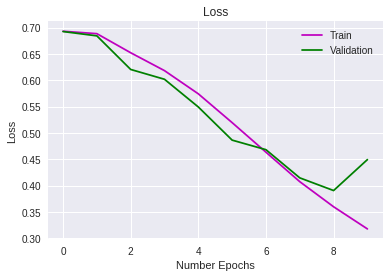

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and validation curve
x = list(range(len(train_errors))) 
plt.plot(x, train_errors,'m',label='Train')
plt.plot(x, eval_errors,'g', label='Validation')

plt.xlabel('Number Epochs')
plt.ylabel('Loss')
plt.legend(loc='best',shadow=True, fancybox=True)
plt.title("Loss")

plt.show()

### Visualize kernels

torch.Size([256, 1, 3, 3])
torch.Size([3, 162, 42])
(162, 42, 3)


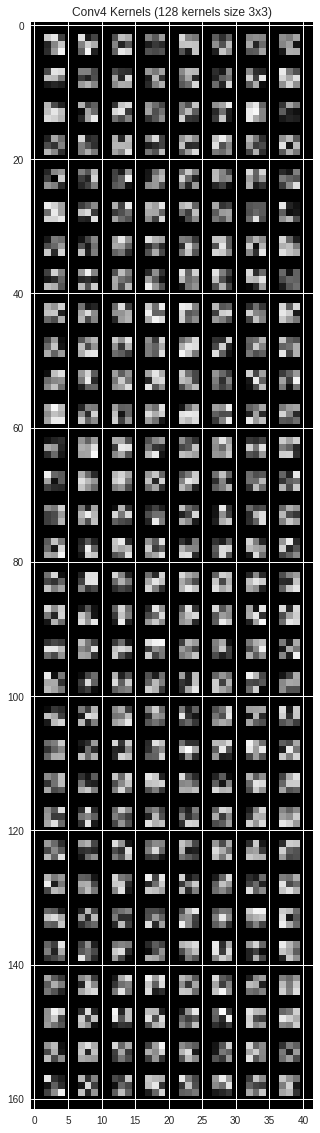

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(inp, cmap='binary')
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


# Visualize kernel
layer = 4
i = 1

kernels = model.state_dict().get('conv{}.0.weight'.format(layer))[:, i:1+1, :, :]
out = torchvision.utils.make_grid(kernels.cpu(), normalize=True)
imshow(out, title="Conv{} Kernels (size 3x3)".format(layer))

### Visualize feature maps

(64, 64, 3)
(138, 274, 3)
(146, 146, 3)
(162, 82, 3)
(194, 50, 3)
tensor(0)
tensor([[0.1843, 0.8157]], device='cuda:0', grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


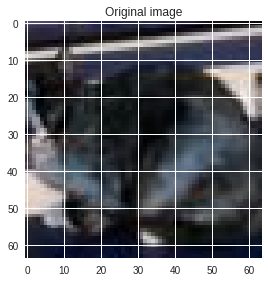

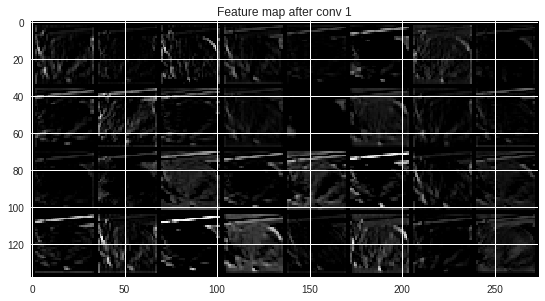

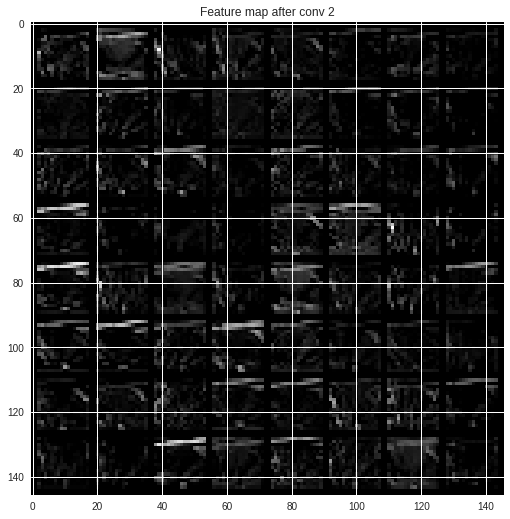

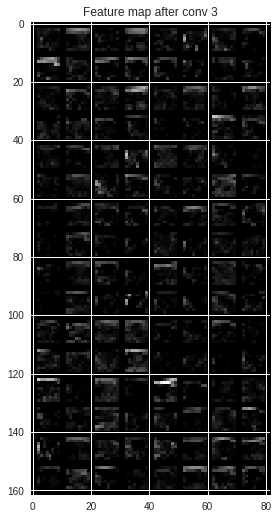

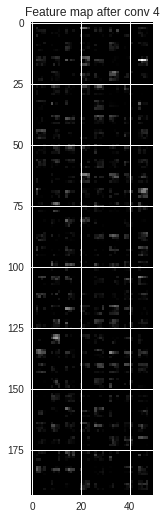

In [0]:
def imshow(inp, title=None, n_rows=1, n_cols=1, index=0, is_input=False):
    """Imshow for Tensor."""
    if len(inp.shape) == 3:
      inp = inp.numpy().transpose((1, 2, 0))
    if is_input:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
    else:
      inp = (inp - inp.min()) / (inp.max()-inp.min())
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    if is_input:
      plt.figure(figsize=(20, 20))
    else:
      plt.figure(figsize=(20, 40))
    plt.subplot(n_rows, n_cols, index)
    plt.imshow(inp, cmap='binary')
    if title is not None:
        plt.title(title)
        
        
s = nn.Softmax()
# Visualize feature maps
for image, label in dataloaders['val']:
  image = image.to(device)[0:1]
  output = model(image)
  imshow(image[0, :, :, :].detach().cpu(), title="Original image", n_rows=4, n_cols=2, index=1, is_input=True)
  for i, out in enumerate(output[1:-2]):
    imshow(torchvision.utils.make_grid(out.transpose(0, 1)).detach().cpu(), title="Feature map after conv {}".format(i+1), n_rows=4, n_cols=2, index=i+1)
  break
print('Label: {}'.format(label[0]))
print('Output: {}'.format(s(output[0])))

### Test CNN

In [0]:
import csv
sub_fn = 'sample_submission'
print('Writing Predictions to CSV...')

tags = ['Cat', 'Dog']
f = open('sample.csv', 'w')
writer = csv.DictWriter(
    f, fieldnames=['id', 'label'])
writer.writeheader()

# model in eval mode
model.eval()

for i, (images, _, paths) in enumerate(testset):
  # images and labels on GPU
  images = images.to(device)
  # forward pass
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  for pred, path in zip(predicted, paths):
    print("pred", pred)
    writer.writerow({'id': path.split('/')[-1].split('.')[0], 'label': tags[pred]})
  
f.close()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
  

In [0]:
!mv sample.csv drive/My\ Drive/'Colab Notebooks'/
!ls drive/My\ Drive/'Colab Notebooks'/

# Hyperparameter Settings



```
|   lr   |   bs   |    loss        | accur. | epochs |     comments    |
-------------------------------------------------------------------------|
|  1e-2  |   16   |CrossEntropyLoss|  83%   |  10
|  1e-2  |   34   |CrossEntropyLoss|  79%   |  10
|  1e-2  |   150  |CrossEntropyLoss|  68%   |  10
|  1e-3  |   34   |CrossEntropyLoss|  64%   |  10
|  1e-3  |   150  |CrossEntropyLoss|  58%   |  10
|  1e-2  |   16   |CrossEntropyLoss|  86%   |  17    | with patience
|  1e-3  |   128  |CrossEntropyLoss|  59%   |  10    | with patience
|  5e-3  |   64   |CrossEntropyLoss|  70%   |  12    | with patience
|  5e-3  |   16   |CrossEntropyLoss|  81%   |  15    | with patience
|  1e-2  |   16   |CrossEntropyLoss|  86%   |  17    | with imgaug, patience
|  1e-2  |   16   |CrossEntropyLoss|  88%   |  19    | with more layers, imgaug, patience
|  1e-2  |   16   |CrossEntropyLoss|  88%   |  19    | with more layers, imgaug, patience
|  5e-3  |   16   |CrossEntropyLoss|  88%   |  32    | with more layers, imgaug, patience
|  5e-3  |   16   |CrossEntropyLoss|  %   |      | with more layers, imgaug, patience, weight decay


```






